In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef, make_scorer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt




In [2]:
# Load dataset
df = pd.read_csv(
    "C:/Users/njann/Desktop/master/SD6101 - Data Science Thinking/Project/S1Data.csv"
)
X = df.drop(["TIME", "Event"], axis=1)
y = df["Event"]
print(X)
print(y)


     Gender  Smoking  Diabetes  BP  Anaemia   Age  Ejection.Fraction  Sodium  \
0         0        0         0   0        1  43.0                 50     135   
1         1        1         1   0        1  73.0                 30     142   
2         1        1         0   1        0  70.0                 20     134   
3         1        0         0   0        1  65.0                 25     141   
4         1        0         0   0        0  64.0                 60     137   
..      ...      ...       ...  ..      ...   ...                ...     ...   
294       0        0         1   0        0  45.0                 55     132   
295       0        0         1   0        0  51.0                 40     134   
296       1        0         0   0        0  45.0                 14     127   
297       1        0         1   0        0  60.0                 45     133   
298       0        0         0   1        1  65.0                 25     137   

     Creatinine  Pletelets   CPK  
0   

In [3]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define hyperparameter grids for each model
param = {
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "algorithm": ["SAMME"]
    },
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
}

# MCC scorer
mcc = make_scorer(matthews_corrcoef)

tuned_models = {}
best_params = {}
best_scores = {}

# Hyperparameter tuning for each model using MCC
for model_name, param_grid in param.items():
    print(f"Tuning {model_name}...")
    if model_name == "AdaBoost":
        model = AdaBoostClassifier(random_state=42)
    elif model_name == "GradientBoosting":
        model = GradientBoostingClassifier(random_state=42)
    elif model_name == "XGBoost":
        model = XGBClassifier(eval_metric="logloss", random_state=42)
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=mcc,
        cv=5,
        n_jobs=-1
    )
    
    grid_search.fit(X_scaled, y)
    
    # Store the best model and best parameters
    tuned_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_
    
    print(f"Best parameters for {model_name}: {best_params[model_name]}")
    print(f"Best MCC score for {model_name}: {best_scores[model_name]:.4f}")



Tuning AdaBoost...
Best parameters for AdaBoost: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 50}
Best MCC score for AdaBoost: 0.3396
Tuning GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best MCC score for GradientBoosting: 0.3764
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best MCC score for XGBoost: 0.3894


In [4]:
results = {
    "AdaBoost": {"accuracy": [], "f1_score": [], "roc_auc": [], "mcc": []},
    "GradientBoosting": {"accuracy": [], "f1_score": [], "roc_auc": [], "mcc": []},
    "XGBoost": {"accuracy": [], "f1_score": [], "roc_auc": [], "mcc": []},
}


feature_ranks = np.zeros(X.shape[1])

# Repeat the experiment 100 times
for i in range(100):
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42 + i
    )
    
    # Use the best parameters found
    for model_name, model in tuned_models.items():
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob > 0.5).astype(int)
        
        results[model_name]["accuracy"].append(accuracy_score(y_test, y_pred))
        results[model_name]["f1_score"].append(f1_score(y_test, y_pred))
        results[model_name]["roc_auc"].append(roc_auc_score(y_test, y_prob))
        results[model_name]["mcc"].append(matthews_corrcoef(y_test, y_pred))
        
        # Accumulate feature rankings for XGBoost
        if model_name == "XGBoost":
            importances = model.feature_importances_
            rankings = np.argsort(importances)[::-1]  
            for rank, index in enumerate(rankings):
                feature_ranks[index] += rank + 1  

# Average the feature rankings over 100 runs 
average_ranks = feature_ranks / 100
print(average_ranks)

# Calculate average metrics for each model and display them in a DataFrame
average_values = {
    model: {metric: np.mean(values) for metric, values in metrics.items()}
    for model, metrics in results.items()
}
print("Average Metrics over 100 Repetitions:", average_values)
metrics = pd.DataFrame(
    {
        "Model": ["AdaBoost", "GradientBoosting", "XGBoost"],
        "Accuracy": [
            average_values["AdaBoost"]["accuracy"],
            average_values["GradientBoosting"]["accuracy"],
            average_values["XGBoost"]["accuracy"],
        ],
        "F1 Score": [
            average_values["AdaBoost"]["f1_score"],
            average_values["GradientBoosting"]["f1_score"],
            average_values["XGBoost"]["f1_score"],
        ],
        "ROC AUC": [
            average_values["AdaBoost"]["roc_auc"],
            average_values["GradientBoosting"]["roc_auc"],
            average_values["XGBoost"]["roc_auc"],
        ],
        "MCC": [
            average_values["AdaBoost"]["mcc"],
            average_values["GradientBoosting"]["mcc"],
            average_values["XGBoost"]["mcc"],
        ],
    }
)
print(metrics)



[6.29 8.89 8.45 7.44 8.37 2.87 1.79 7.11 1.53 7.32 5.94]
Average Metrics over 100 Repetitions: {'AdaBoost': {'accuracy': np.float64(0.7329999999999999), 'f1_score': np.float64(0.5135629779020211), 'roc_auc': np.float64(0.7631035401693522), 'mcc': np.float64(0.34907818257592377)}, 'GradientBoosting': {'accuracy': np.float64(0.7186666666666666), 'f1_score': np.float64(0.5327771748361476), 'roc_auc': np.float64(0.7472164468089136), 'mcc': np.float64(0.34119030070062645)}, 'XGBoost': {'accuracy': np.float64(0.7397777777777779), 'f1_score': np.float64(0.5218263961568346), 'roc_auc': np.float64(0.7775519744854745), 'mcc': np.float64(0.368361207982974)}}
              Model  Accuracy  F1 Score   ROC AUC       MCC
0          AdaBoost  0.733000  0.513563  0.763104  0.349078
1  GradientBoosting  0.718667  0.532777  0.747216  0.341190
2           XGBoost  0.739778  0.521826  0.777552  0.368361


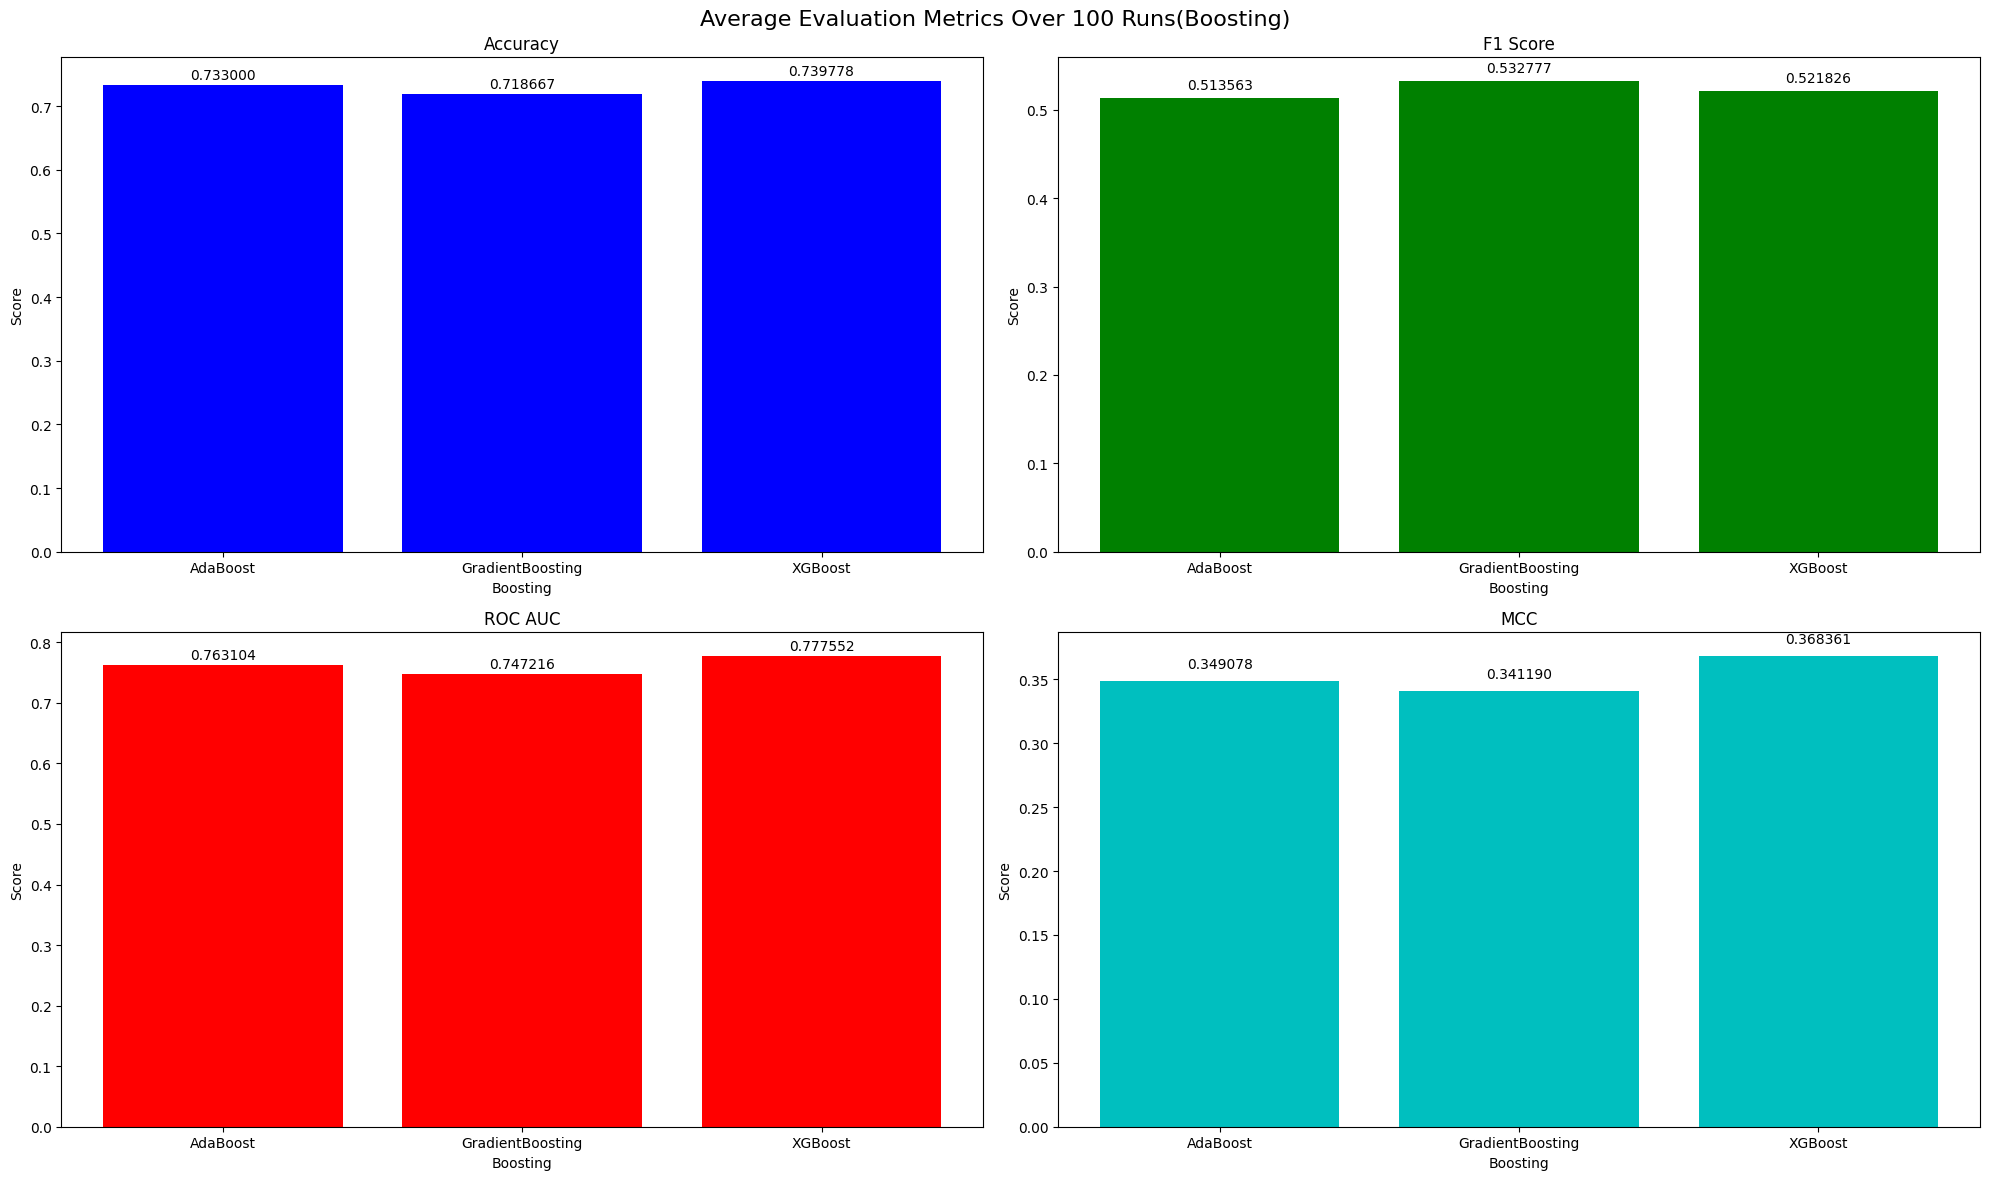

In [5]:
# Plotting the bar chart for comparison of metrics
fig, axes = plt.subplots(2, 2, figsize=(20,12))
fig.suptitle('Average Evaluation Metrics Over 100 Runs(Boosting)', fontsize=16)
# Accuracy
axes[0, 0].bar(metrics["Model"], metrics["Accuracy"], color = 'b')
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_xlabel('Boosting')
axes[0, 0].set_ylabel("Score")
for i, v in enumerate(metrics["Accuracy"]):
    axes[0, 0].text(i, v + 0.01, f"{v:.6f}", ha="center")

# F1 Score
axes[0, 1].bar(metrics["Model"], metrics["F1 Score"],color = 'g')
axes[0, 1].set_title("F1 Score")
axes[0, 1].set_xlabel('Boosting')
axes[0, 1].set_ylabel("Score")
for i, v in enumerate(metrics["F1 Score"]):
    axes[0, 1].text(i, v + 0.01, f"{v:.6f}", ha="center")

# ROC AUC
axes[1, 0].bar(metrics["Model"], metrics["ROC AUC"], color = 'r')
axes[1, 0].set_title("ROC AUC")
axes[1, 0].set_xlabel('Boosting')
axes[1, 0].set_ylabel("Score")
for i, v in enumerate(metrics["ROC AUC"]):
    axes[1, 0].text(i, v + 0.01, f"{v:.6f}", ha="center")

# MCC
axes[1, 1].bar(metrics["Model"], metrics["MCC"], color = 'c')
axes[1, 1].set_title("MCC")
axes[1, 1].set_xlabel('Boosting')
axes[1, 1].set_ylabel("Score")
for i, v in enumerate(metrics["MCC"]):
    axes[1, 1].text(i, v + 0.01, f"{v:.6f}", ha="center")

plt.tight_layout()
plt.show()


              Feature  Average Rank
0          Creatinine          1.53
1   Ejection.Fraction          1.79
2                 Age          2.87
3                 CPK          5.94
4              Gender          6.29
5              Sodium          7.11
6           Pletelets          7.32
7                  BP          7.44
8             Anaemia          8.37
9            Diabetes          8.45
10            Smoking          8.89


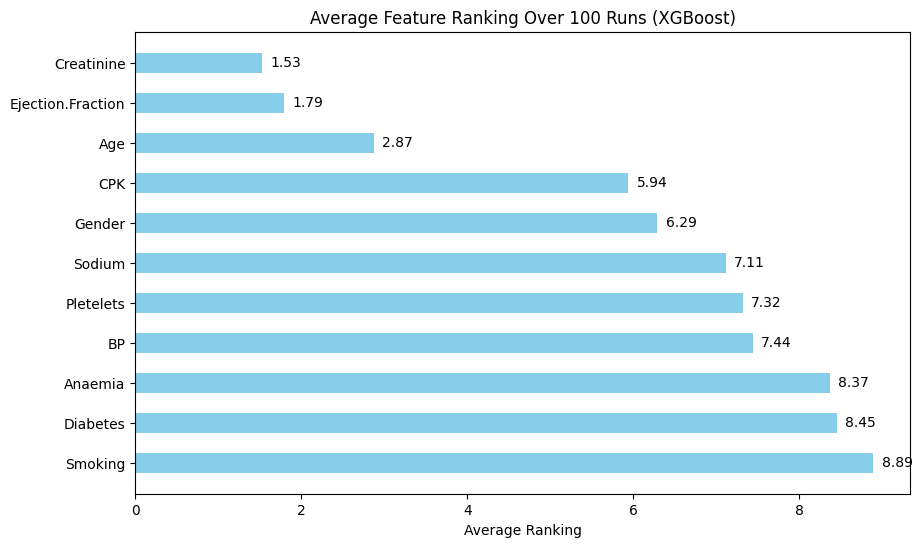

In [7]:
average_ranking = pd.DataFrame({
    "Feature": X.columns,
    "Average Rank": average_ranks
})

# Sort the DataFrame by average rank 
average_ranking = average_ranking.sort_values(by="Average Rank").reset_index(drop=True)
print(average_ranking)
# Plotting the average feature ranking
plt.figure(figsize=(10, 6))
bars = plt.barh(average_ranking["Feature"], average_ranking["Average Rank"], color = 'Skyblue', height=0.5, align='center')
plt.xlabel('Average Ranking')
plt.title('Average Feature Ranking Over 100 Runs (XGBoost)')
plt.gca().invert_yaxis()
for bar, rank in zip(bars, average_ranking["Average Rank"]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f"{rank:.2f}", va='center')

plt.show()
